In [128]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = 20,20

sns.set_style(style="darkgrid")

In [129]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## What is the gender split in our database?

In [130]:

gender_df = df.groupby("gender").count()
gender_df = gender_df.rename({"id": "count"}, axis="columns")
gender_df

,count,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,,,,,,,,,,,
Female,2994,2994,2994,2994,2994,2994,2994,2994,2897,2994,2994
Male,2115,2115,2115,2115,2115,2115,2115,2115,2011,2115,2115
Other,1,1,1,1,1,1,1,1,1,1,1


We can see that there's an outlier in our data, so we are gonna need to remove it first.

<AxesSubplot:xlabel='gender', ylabel='count'>

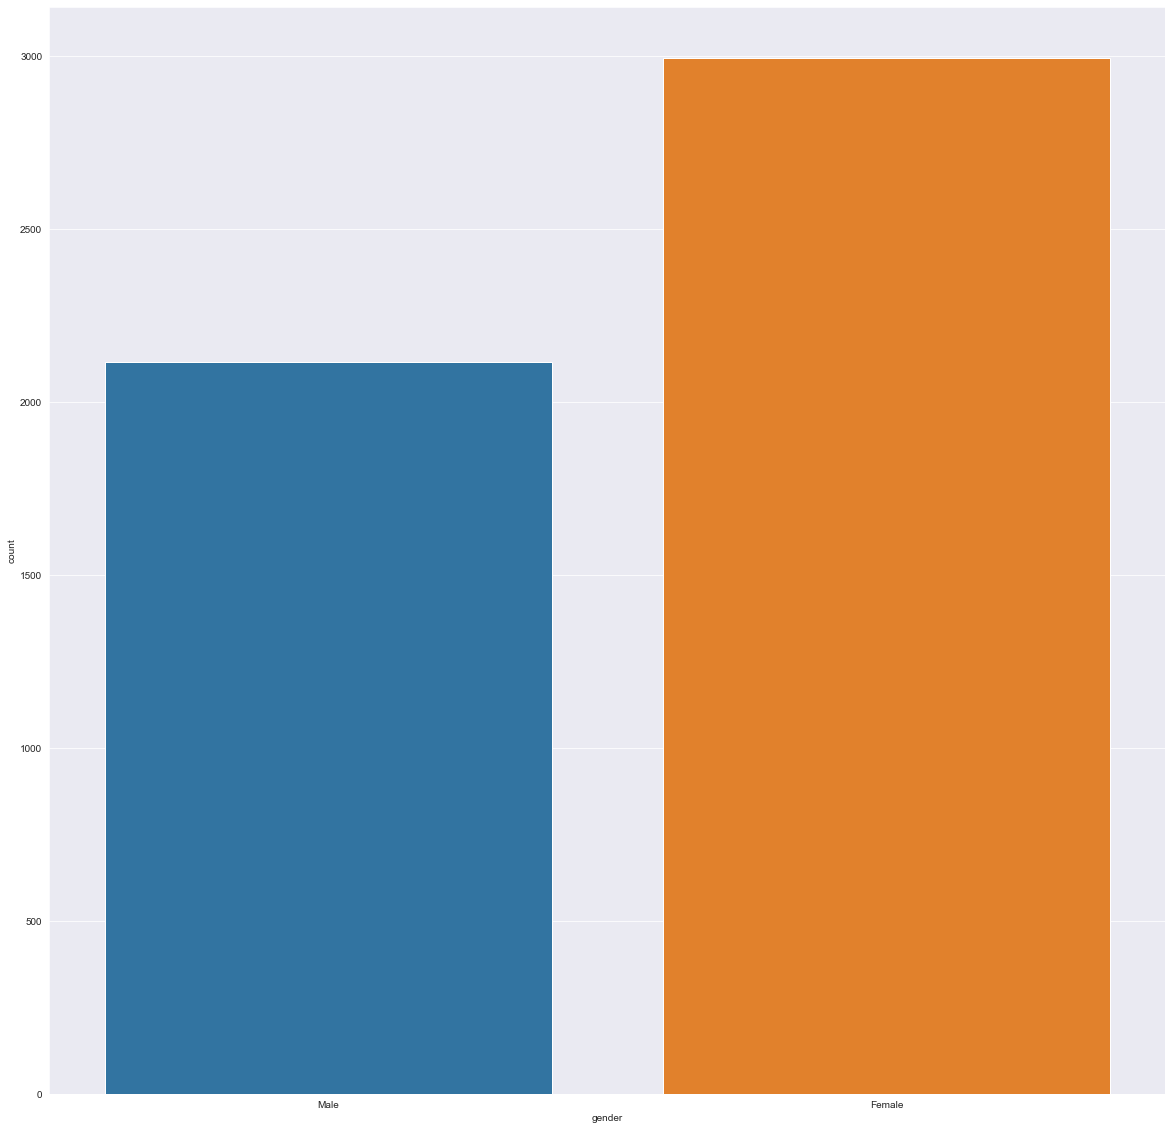

In [131]:
gender_outlier_index = df[df["gender"] == "Other"].index
df = df.drop(gender_outlier_index)

sns.countplot(x="gender", data=df)

<AxesSubplot:xlabel='age', ylabel='count'>

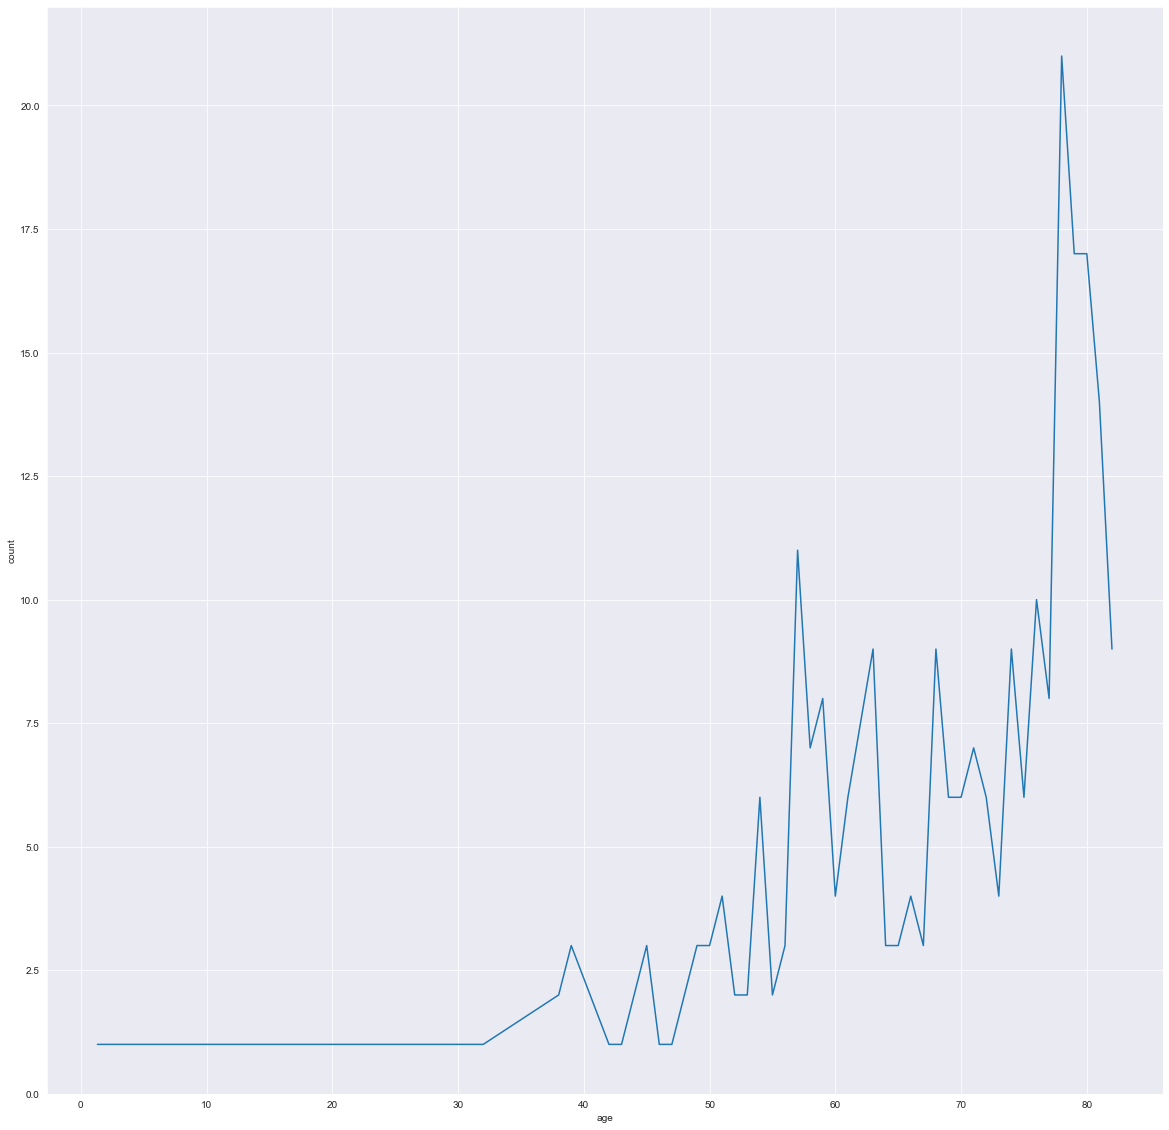

In [132]:
stroke_df = df[df["stroke"] == 1]
stroke_df = stroke_df.groupby("age").count()
stroke_df = stroke_df.rename({"id": "count"}, axis="columns")
sns.lineplot(x="age", y="count", data=stroke_df)

In [133]:
def gender_formatter(data):
    # print(data)
    if (data == "Female"):
        return 0
    return 1

df["gender"] = df["gender"].apply(gender_formatter)

df = df.dropna()

In [137]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df["ever_married"])
df["ever_married"] = label_encoder.transform(df["ever_married"])

label_encoder.fit(df["Residence_type"])
df["Residence_type"] = label_encoder.transform(df["Residence_type"])

label_encoder.fit(df["work_type"])
df["work_type"] = label_encoder.transform(df["work_type"])

label_encoder.fit(df["smoking_status"])
df["smoking_status"] = label_encoder.transform(df["smoking_status"])

df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,56669,1,81.0,0,0,1,2,1,186.21,29.0,1,1


In [150]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Define Features
X = df.drop("stroke", axis=1)

# Define Targets
y = df["stroke"]

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y)

training_scores = []
testing_scores = []
k_range = range(1, 101) 

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    training_score = knn.score(X_train, y_train)
    testing_score = knn.score(X_test, y_test)

    training_scores.append(training_score)
    testing_scores.append(testing_score)

    # print("K:", k)
    # print("Train:", training_score)
    # print("Test:", testing_score)
    # print()

In [153]:
knn_df = pd.DataFrame({"training": training_scores, "testing": testing_scores})
# "k": k_range, 
knn_df
# x="k", y="score", 
sns.lineplot(data=testing_df)

,k,training,testing
0,1,1.000000,0.934800
1,2,0.958979,0.956805
2,3,0.957892,0.955175
3,4,0.956805,0.960065
4,5,0.957349,0.960065
...,...,...,...
95,96,0.956805,0.959250
96,97,0.956805,0.959250
97,98,0.956805,0.959250
98,99,0.956805,0.959250
